### Import Required Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from io import BytesIO
import requests
import os

In [2]:
storage_account = "w281saysxxfypm"
isic_container_name = "isic2019-images"
ham_container_name = "ham-10000-images"
isic_blob_prefix = "isic_2019/"
ham_blob_prefix = "ham10000/"


### Load ISIC 2019 Training Metadata

In [3]:
url = f"https://{storage_account}.blob.core.windows.net/{isic_container_name}/{isic_blob_prefix}training_data/ISIC_0000000.jpg"
response = requests.get(url)
image = Image.open(BytesIO(response.content))
image.show()

Load ISIC 2019 Training Metadata

In [4]:
csv_url = f"https://{storage_account}.blob.core.windows.net/{isic_container_name}/{isic_blob_prefix}ISIC_2019_Training_Metadata.csv"
isic_metadata_df = pd.read_csv(csv_url)
isic_metadata_df.head()

image  age_approx anatom_site_general lesion_id     sex
0  ISIC_0000000        55.0      anterior torso       NaN  female
1  ISIC_0000001        30.0      anterior torso       NaN  female
2  ISIC_0000002        60.0     upper extremity       NaN  female
3  ISIC_0000003        30.0     upper extremity       NaN    male
4  ISIC_0000004        80.0     posterior torso       NaN    male

In [5]:
isic_metadata_df.shape


(25331, 5)

Load ISIC 2019 Ground Truth Metadata

In [6]:
gt_csv_url = f"https://{storage_account}.blob.core.windows.net/{isic_container_name}/{isic_blob_prefix}training_ground_truth/ISIC_2019_Training_GroundTruth.csv"
gt_df = pd.read_csv(gt_csv_url)
gt_df.head()

image  MEL   NV  BCC   AK  BKL   DF  VASC  SCC  UNK
0  ISIC_0000000  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
1  ISIC_0000001  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
2  ISIC_0000002  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
3  ISIC_0000003  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
4  ISIC_0000004  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0

### Load HAM10000 Training Metadata

In [7]:
csv_url = f"https://{storage_account}.blob.core.windows.net/{ham_container_name}/{ham_blob_prefix}HAM10000_metadata.csv"
ham_metadata_df = pd.read_csv(csv_url)
ham_metadata_df.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [8]:
ham_metadata_df.shape

(10015, 7)

Preview the Data

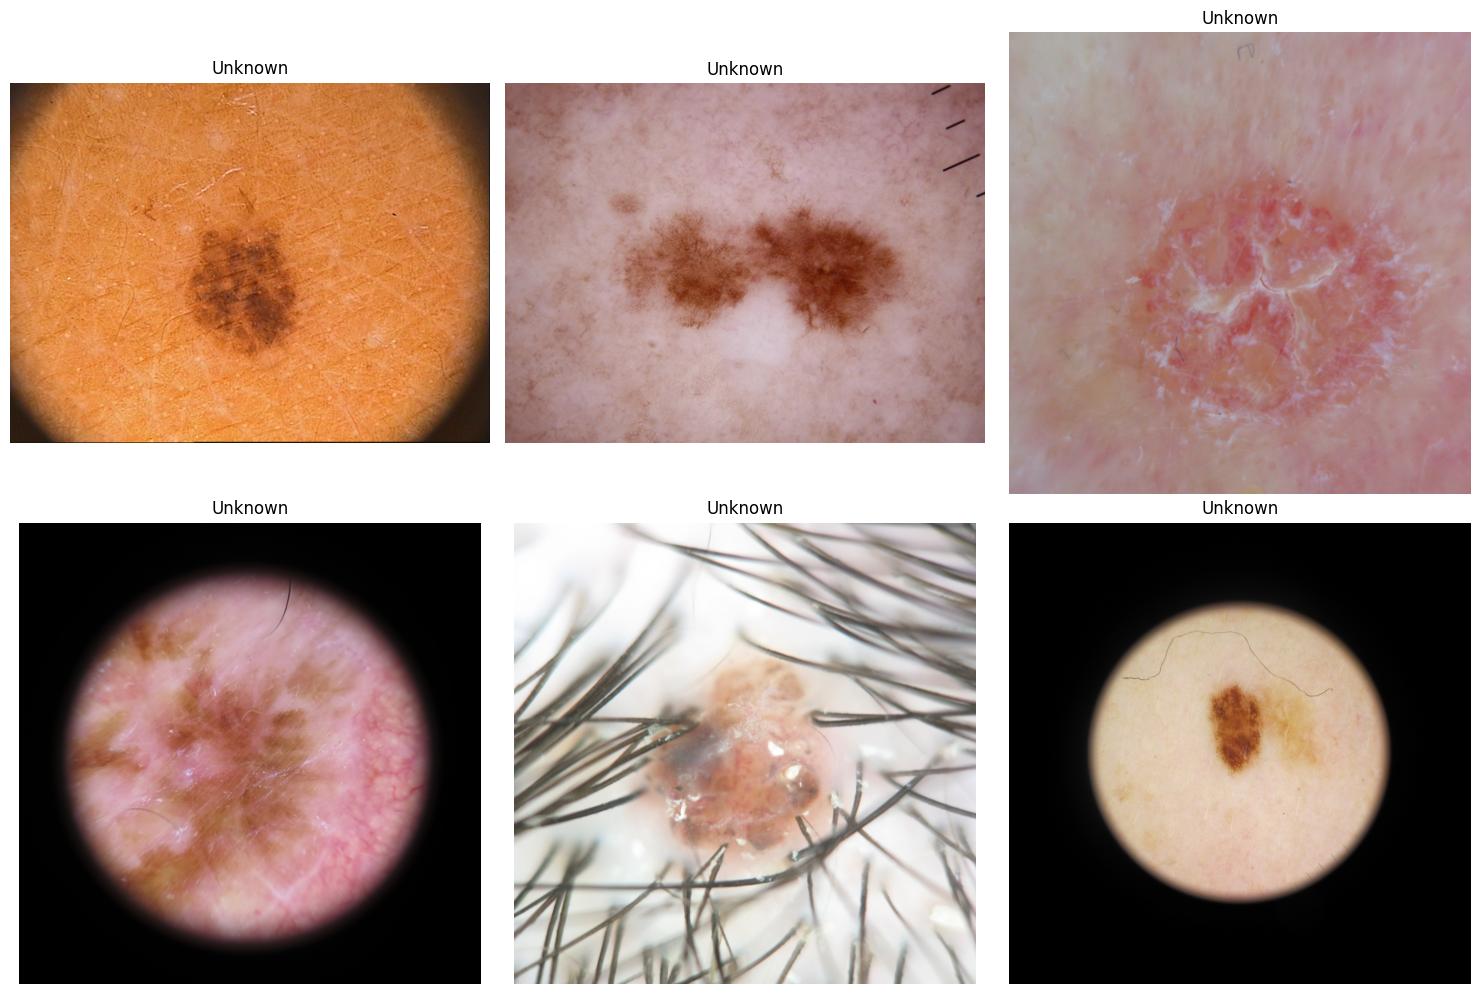

In [9]:
# Preview 6 images from the dataset
sample_images = isic_metadata_df.sample(6, random_state=42)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Display each image in the sample
for ax, (_, row) in zip(axes.flatten(), sample_images.iterrows()):
    image_url = f"https://{storage_account}.blob.core.windows.net/{isic_container_name}/{isic_blob_prefix}training_data/{row['image']}.jpg"
    response = requests.get(image_url)
    if response.status_code == 200:
        try:
            img = Image.open(BytesIO(response.content))
            ax.imshow(img)
            ax.set_title(row.get('lesion_type', 'Unknown'))
        except Exception as e:
            ax.text(0.5, 0.5, 'Image Error', ha='center', va='center')
            ax.set_title('Error')
    else:
        ax.text(0.5, 0.5, 'Not Found', ha='center', va='center')
        ax.set_title('Not Found')
    ax.axis('off')
plt.tight_layout()
plt.show()

Load Metadata Files

In [10]:
ham_df = pd.read_csv(f"https://{storage_account}.blob.core.windows.net/{ham_container_name}/{ham_blob_prefix}HAM10000_metadata.csv")
isic_df = pd.read_csv(f"https://{storage_account}.blob.core.windows.net/{isic_container_name}/{isic_blob_prefix}ISIC_2019_Training_Metadata.csv")
isic_groundtruth_df = pd.read_csv(f"https://{storage_account}.blob.core.windows.net/{isic_container_name}/{isic_blob_prefix}training_ground_truth/ISIC_2019_Training_GroundTruth.csv")

In [11]:
# List of diagnosis columns
dx_cols = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']

# Find the diagnosis for each row
isic_groundtruth_df['dx'] = isic_groundtruth_df[dx_cols].idxmax(axis=1)

In [12]:
# Merge on 'image' to include ground truth diagnosis from isic_groundtruth_df
isic_df = isic_df.merge(isic_groundtruth_df[['image', 'dx']], on='image', how='left')
isic_df.head()

image  age_approx anatom_site_general lesion_id     sex   dx
0  ISIC_0000000        55.0      anterior torso       NaN  female   NV
1  ISIC_0000001        30.0      anterior torso       NaN  female   NV
2  ISIC_0000002        60.0     upper extremity       NaN  female  MEL
3  ISIC_0000003        30.0     upper extremity       NaN    male   NV
4  ISIC_0000004        80.0     posterior torso       NaN    male  MEL

In [13]:
isic_df.shape

(25331, 6)

### Preview the Data

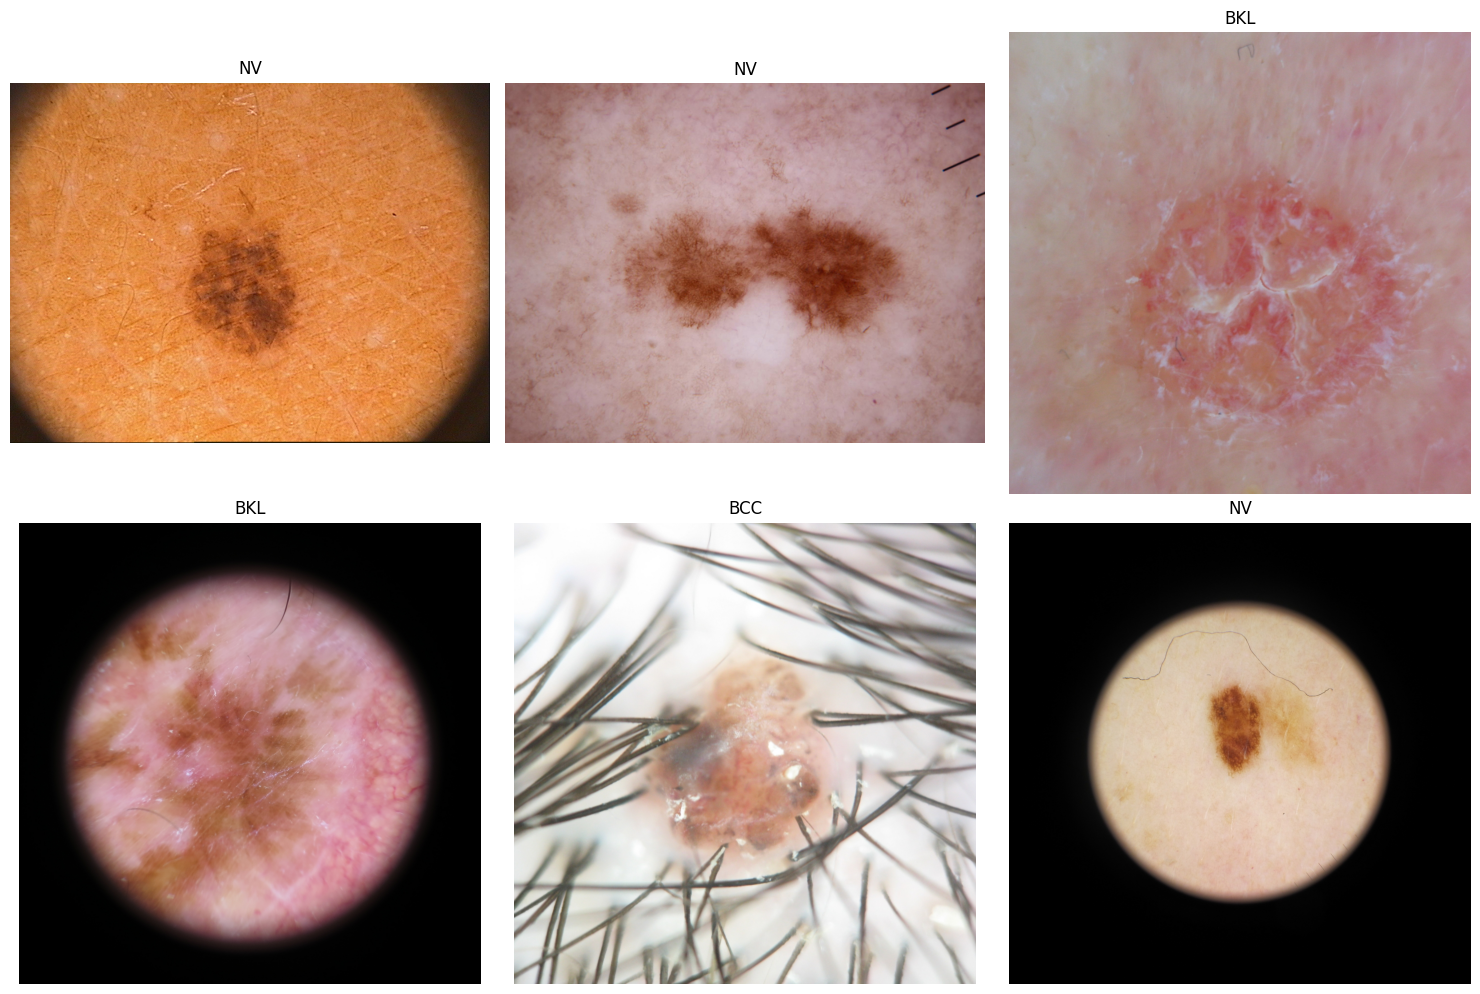

In [14]:
# Preview the images with their diagnoses
sample_images = isic_df.sample(6, random_state=42)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
# Display each image in the sample
for ax, (_, row) in zip(axes.flatten(), sample_images.iterrows()):
    image_url = f"https://{storage_account}.blob.core.windows.net/{isic_container_name}/{isic_blob_prefix}training_data/{row['image']}.jpg"
    response = requests.get(image_url)
    if response.status_code == 200:
        try:
            img = Image.open(BytesIO(response.content))
            ax.imshow(img)
            ax.set_title(row['dx'] if 'dx' in row else 'Unknown')
        except Exception as e:
            ax.text(0.5, 0.5, 'Image Error', ha='center', va='center')
            ax.set_title('Error')
    else:
        ax.text(0.5, 0.5, 'Not Found', ha='center', va='center')
        ax.set_title('Not Found')
    ax.axis('off')
plt.tight_layout()
plt.show()


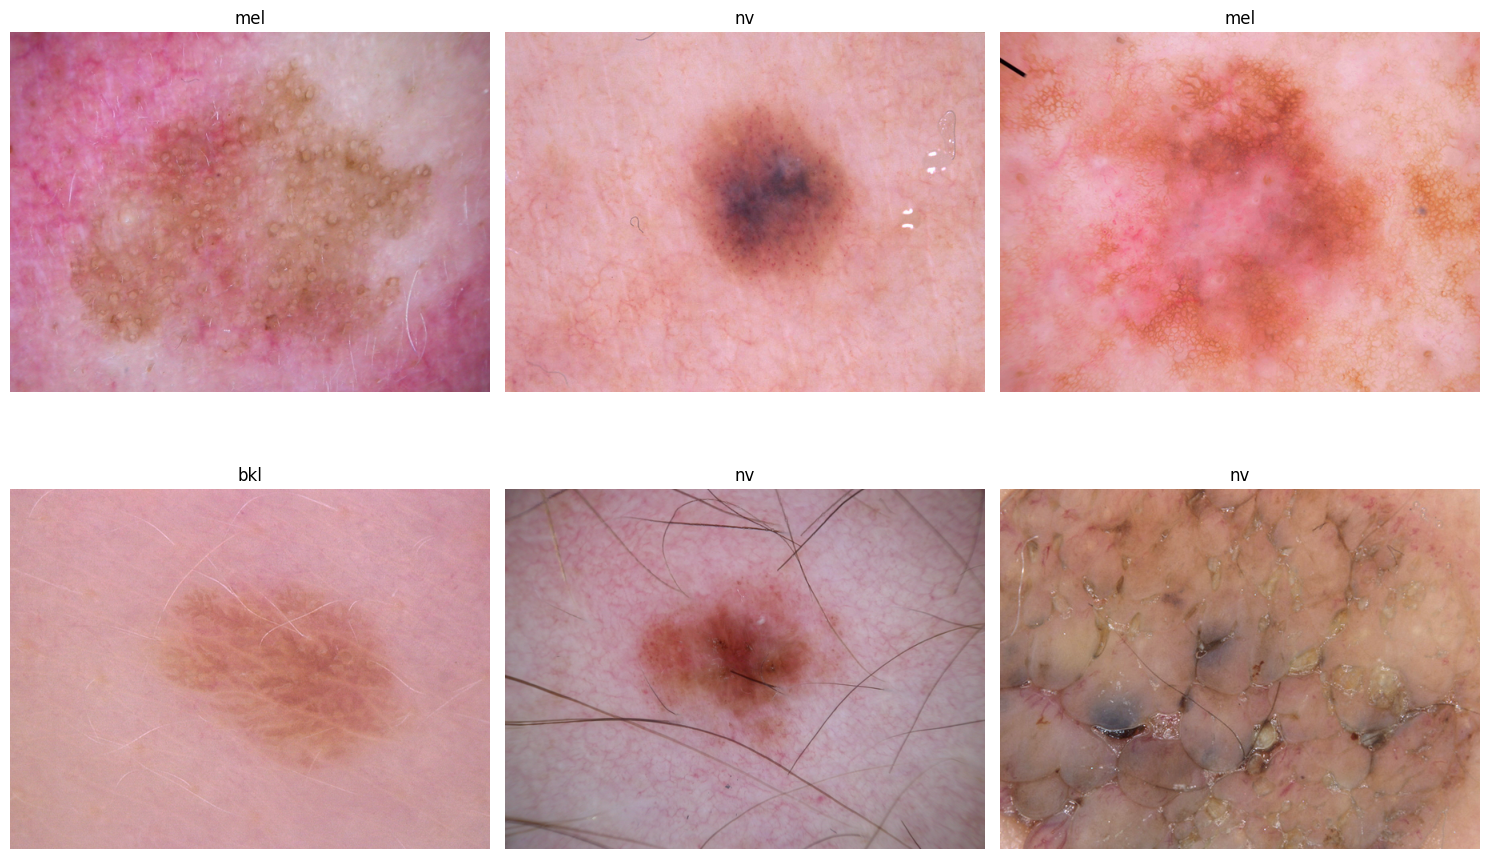

In [15]:
# Preview the images with their diagnoses for the HAM10000 dataset from both part_1 and part_2
sample_images = ham_df.sample(6, random_state=42)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for ax, (_, row) in zip(axes.flatten(), sample_images.iterrows()):
    found = False
    for part in ["HAM10000_images_part_1", "HAM10000_images_part_2"]:
        image_url = f"https://{storage_account}.blob.core.windows.net/{ham_container_name}/{ham_blob_prefix}{part}/{row['image_id']}.jpg"
        response = requests.get(image_url)
        if response.status_code == 200:
            try:
                img = Image.open(BytesIO(response.content))
                ax.imshow(img)
                ax.set_title(row['dx'] if 'dx' in row else 'Unknown')
                found = True
                break
            except Exception as e:
                ax.text(0.5, 0.5, 'Image Error', ha='center', va='center')
                ax.set_title('Error')
                found = True
                break
    if not found:
        ax.text(0.5, 0.5, 'Not Found', ha='center', va='center')
        ax.set_title('Not Found')
        print(f"Image not found: {row['image_id']}")
    ax.axis('off')
plt.tight_layout()
plt.show()


### Check the datasets diagnoses distribution

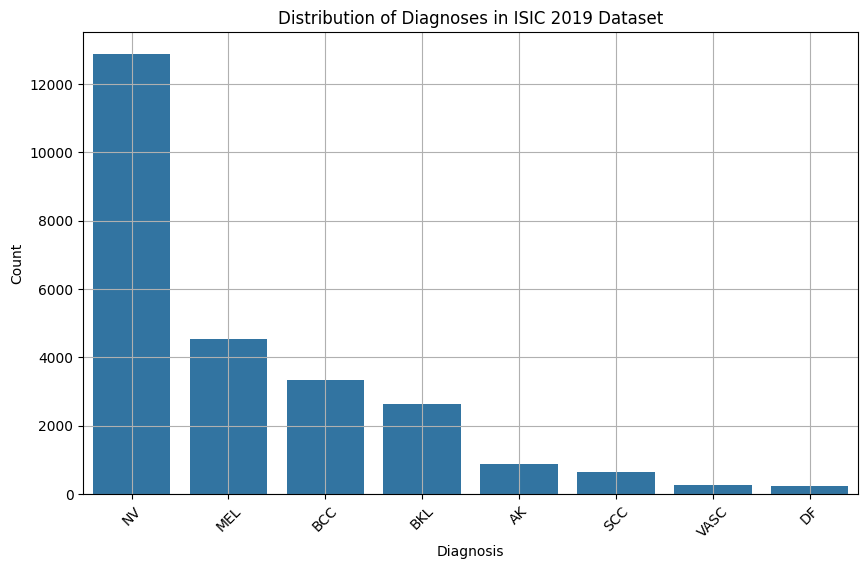

In [16]:
# Display the distribution of diagnoses in the dataset
plt.figure(figsize=(10, 6))
sns.countplot(data=isic_df, x='dx', order=isic_df['dx'].value_counts().index)
plt.title('Distribution of Diagnoses in ISIC 2019 Dataset')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


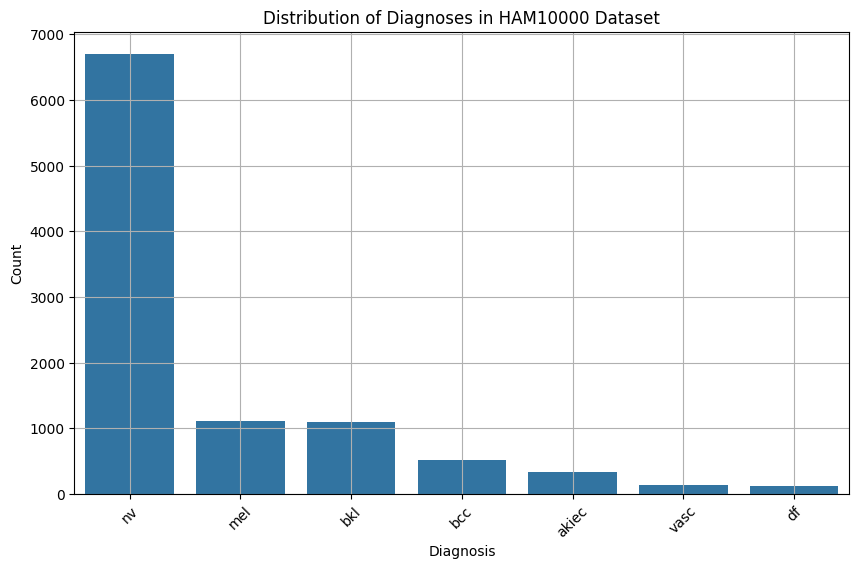

In [17]:
# Display the distribution of diagnoses in the ham dataset
plt.figure(figsize=(10, 6))
sns.countplot(data=ham_df, x='dx', order=ham_df['dx'].value_counts().index)
plt.title('Distribution of Diagnoses in HAM10000 Dataset')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

### Save the datasets for feature extraction notebook

In [ ]:
data_path = "../data"

# Ensure the 'data' directory exists
os.makedirs(data_path, exist_ok=True)

# Save the ISIC DataFrame with ground truth diagnosis to a CSV file
isic_df.to_csv(os.path.join(data_path, "isic_with_ground_truth.csv"), index=False)

# Save the HAM DataFrame to a CSV file
ham_df.to_csv(os.path.join(data_path, "ham_with_diagnosis.csv"), index=False)